In [226]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
import numpy as np

In [162]:
juvenile_df = pd.read_csv('../Data/juvenile_clean.csv', index_col = 0, dtype={5: str})

In [163]:
juvenile_df['CheckoutDate'] = pd.to_datetime(juvenile_df['CheckoutDate'])

## General Data Description

In [164]:
juvenile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6443528 entries, 0 to 6443527
Data columns (total 23 columns):
 #   Column            Dtype         
---  ------            -----         
 0   UsageClass        object        
 1   MaterialType      object        
 2   Checkouts         int64         
 3   Title             object        
 4   ISBN              object        
 5   Creator           object        
 6   Subjects          object        
 7   Publisher         object        
 8   PublicationYear   object        
 9   CheckoutDate      datetime64[ns]
 10  TitleNotes        object        
 11  CreatorName       object        
 12  CopyrightList     object        
 13  CopyrightDate     float64       
 14  PCopyrightList    object        
 15  PCopyrightDate    float64       
 16  PrintingDate      float64       
 17  ApproxDate        float64       
 18  PubDate           float64       
 19  OtherDateList     object        
 20  OtherDate         float64       
 21  CreatedDate  

In [165]:
juvenile_df['UsageClass'].value_counts(dropna=False)

UsageClass
Physical    4528917
Digital     1914611
Name: count, dtype: int64

In [166]:
juvenile_df['MaterialCategory'].value_counts()

MaterialCategory
Book         4232868
E-book       1416036
Audiobook     708660
Video          83725
Other           1467
Music            772
Name: count, dtype: int64

In [167]:
juvenile_df['CheckoutDate'].describe()

count                          6443528
mean     2018-01-15 22:05:10.878637312
min                2005-04-01 00:00:00
25%                2014-05-01 00:00:00
50%                2018-08-01 00:00:00
75%                2022-08-01 00:00:00
max                2025-11-01 00:00:00
Name: CheckoutDate, dtype: object

In [168]:
books_df = juvenile_df.loc[juvenile_df.MaterialCategory.isin(['Book', 'E-book', 'Audiobook'])].reset_index()

In [169]:
books_df[['Title', 'CreatorName']].drop_duplicates().shape[0]

127254

In [170]:
books_df['CheckoutDate'].describe()

count                          6357564
mean     2018-02-06 14:50:34.848442112
min                2005-04-01 00:00:00
25%                2014-06-01 00:00:00
50%                2018-09-01 00:00:00
75%                2022-09-01 00:00:00
max                2025-11-01 00:00:00
Name: CheckoutDate, dtype: object

## Most Popular Books

### Overall top books

In [171]:
top10_overall = books_df.groupby(['CreatorName', 'Title'], as_index = False).agg(Checkouts = ('Checkouts', 'sum'), Created = ('CreatedDate', 'min')).sort_values('Checkouts', ascending = False).head(10).rename(columns = {'Checkouts': 'TotalCheckouts'})

In [172]:
top10_overall = pd.merge(top10_overall, books_df.groupby(['CreatorName', 'Title', 'UsageClass'], as_index = False)['Checkouts'].sum(), how = 'inner', on = ['CreatorName', 'Title']).pivot(index = ['CreatorName', 'Title', 'Created', 'TotalCheckouts'], columns = 'UsageClass', values = 'Checkouts').reset_index().sort_values('TotalCheckouts', ascending = False).reset_index(drop = True)

In [173]:
top10_overall

UsageClass,CreatorName,Title,Created,TotalCheckouts,Digital,Physical
0,J. K. Rowling,Harry Potter And The Sorcerer's Stone,1998.0,34694,19913.0,14781.0
1,J. K. Rowling,Harry Potter And The Chamber Of Secrets,1999.0,27910,16057.0,11853.0
2,J. K. Rowling,Harry Potter And The Prisoner Of Azkaban,1999.0,22054,11985.0,10069.0
3,J. K. Rowling,Harry Potter And The Half-Blood Prince,2005.0,20203,6369.0,13834.0
4,J. K. Rowling,Harry Potter And The Deathly Hallows,2007.0,17710,6129.0,11581.0
5,J. K. Rowling,Harry Potter And The Goblet Of Fire,2000.0,17060,7233.0,9827.0
6,J. K. Rowling,Harry Potter And The Order Of The Phoenix,2003.0,16606,6704.0,9902.0
7,R. J. Palacio,Wonder,2012.0,16007,7683.0,8324.0
8,Madeleine L'Engle,A Wrinkle In Time,1962.0,15963,6706.0,9257.0
9,Mo Willems,Are You Ready To Play Outside?,2008.0,12774,NaN,12774.0


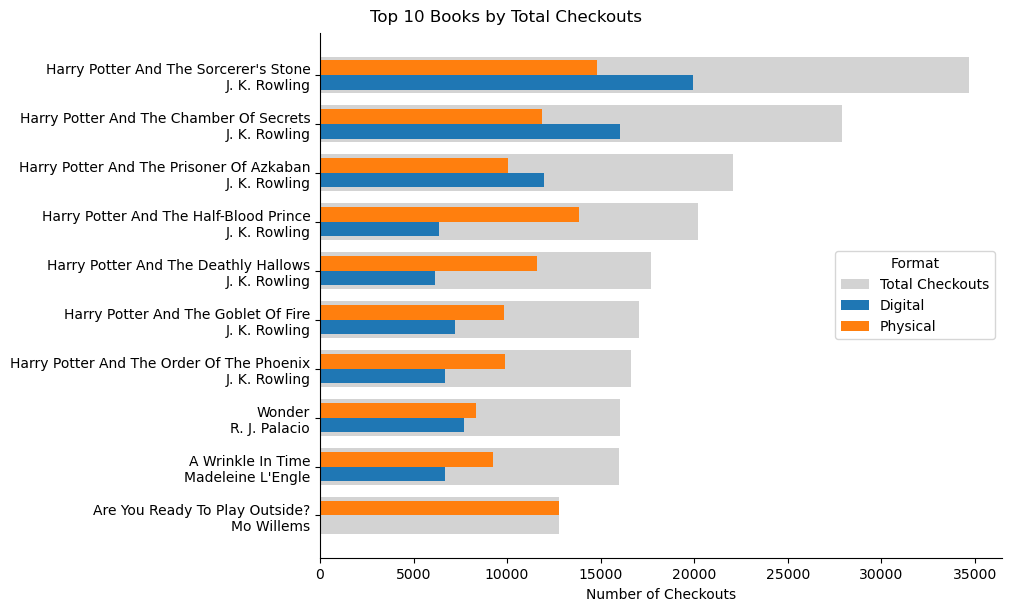

In [174]:
##resort data for graphing
df = top10_overall.sort_values('TotalCheckouts').reset_index(drop = True)

## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

bar_width = 0.3
y = np.arange(10)

ax.barh(y, df['TotalCheckouts'], height = bar_width * 2.5, color = 'lightgray', zorder = 0, label = 'Total Checkouts')

for i, type in enumerate(df[['Digital', 'Physical']]):
    ax.barh(y + (i * bar_width) - (bar_width/2), df[type], height = bar_width, label = type)

## Graph title
plt.suptitle('Top 10 Books by Total Checkouts')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Number of Checkouts")
ax.set_yticks(y)
ax.set_yticklabels(df.Title + '\n' + df.CreatorName)
ax.legend(title="Format")

plt.show()

### Top Books by Avg Checkouts

In [184]:
avg_checkouts = books_df.groupby(['CreatorName', 'Title'], as_index = False).agg(Months = ('CheckoutDate', 'nunique'), TotalCheckouts = ('Checkouts', 'sum'))

In [185]:
avg_checkouts['CheckoutsPerMonth'] = avg_checkouts['TotalCheckouts'] / avg_checkouts['Months']

In [186]:
top_avg_checkouts = avg_checkouts.loc[avg_checkouts['Months'] >= 12].sort_values('CheckoutsPerMonth').tail(10)

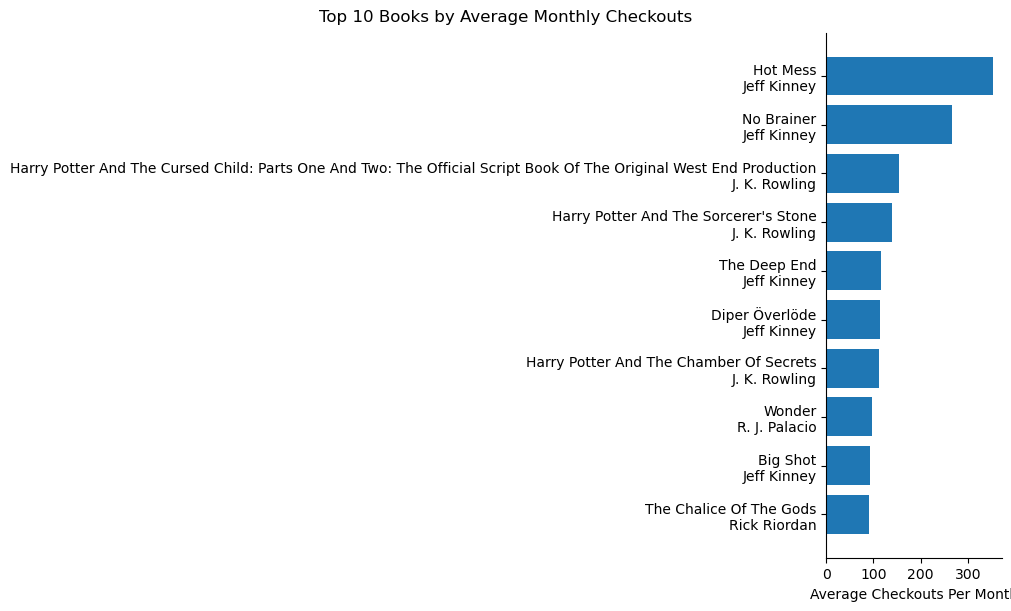

In [187]:
## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

ax.barh(np.arange(10), top_avg_checkouts['CheckoutsPerMonth'])

## Graph title
plt.suptitle('Top 10 Books by Average Monthly Checkouts')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Average Checkouts Per Month")
ax.set_yticks(np.arange(10))
ax.set_yticklabels(top_avg_checkouts.Title + '\n' + top_avg_checkouts.CreatorName)

plt.show()

### Top *median* monthly checkouts

In [188]:
med_checkouts = books_df.groupby(['CreatorName', 'Title', 'CheckoutDate'], as_index = False)['Checkouts'].sum()

In [189]:
med_checkouts = med_checkouts.groupby(['CreatorName', 'Title'], as_index = False).agg(Months = ('CheckoutDate', 'nunique'), MedCheckouts = ('Checkouts', 'median'))

In [190]:
top_med_checkouts = med_checkouts.loc[med_checkouts['Months'] >= 12].sort_values('MedCheckouts').tail(10)

In [191]:
top_med_checkouts

,CreatorName,Title,Months,MedCheckouts
51647,Jeff Kinney,Wrecking Ball,73,85.0
25532,Dav Pilkey,"Grime And Punishment: Dog Man Series, Book 9",30,94.0
96871,Rick Riordan,The Chalice Of The Gods,27,101.0
46526,J. K. Rowling,Harry Potter And The Sorcerer's Stone,248,111.0
51483,Jeff Kinney,Big Shot,49,117.0
51611,Jeff Kinney,The Deep End,62,119.0
51538,Jeff Kinney,Diper Överlöde,37,121.0
46520,J. K. Rowling,Harry Potter And The Cursed Child: Parts One A...,26,180.0
51589,Jeff Kinney,No Brainer,26,235.5
51579,Jeff Kinney,Hot Mess,14,326.5


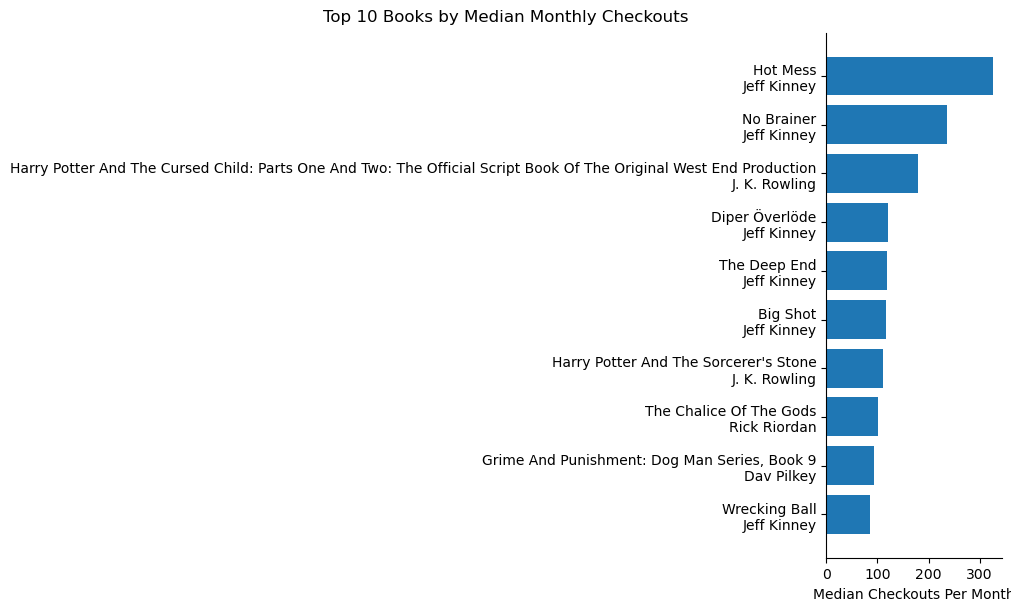

In [192]:
## Build the graph
fig, ax = plt.subplots(figsize = (10,6), layout = 'constrained')

ax.barh(np.arange(10), top_med_checkouts['MedCheckouts'])

## Graph title
plt.suptitle('Top 10 Books by Median Monthly Checkouts')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Median Checkouts Per Month")
ax.set_yticks(np.arange(10))
ax.set_yticklabels(top_med_checkouts.Title + '\n' + top_med_checkouts.CreatorName)

plt.show()

## Most Popular Authors

In [217]:
top_authors = books_df.groupby(['CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum().groupby('CreatorName', as_index = False).agg(TotalCheckouts = ('Checkouts', 'sum'), AvgMonthlyCheckouts = ('Checkouts', 'mean'))

### Top by most overall checkouts

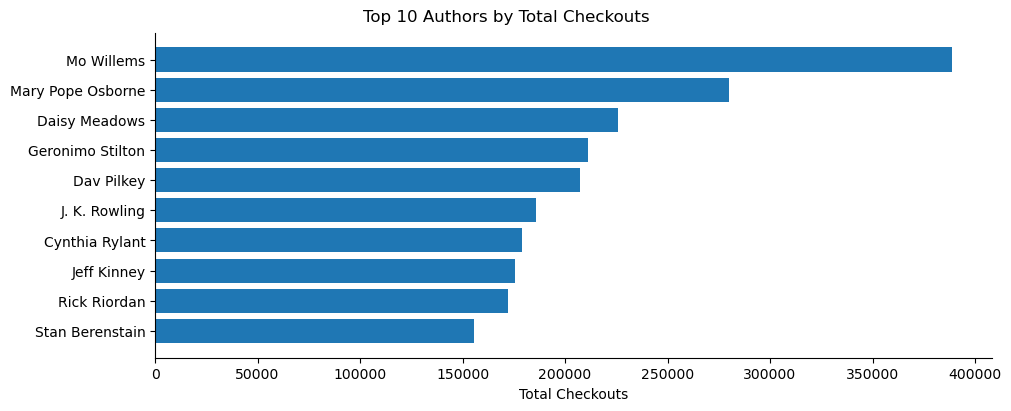

In [220]:
## Sort data to graph
top_authors_overall = top_authors.sort_values('TotalCheckouts').tail(10)

## Build graph
fig, ax = plt.subplots(figsize = (10,4), layout = 'constrained')

ax.barh(np.arange(10), top_authors_overall['TotalCheckouts'])

## Graph title
plt.suptitle('Top 10 Authors by Total Checkouts')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Total Checkouts")
ax.set_yticks(np.arange(10))
ax.set_yticklabels(top_authors_overall['CreatorName'])

plt.show()

### Top by avg checkouts per month

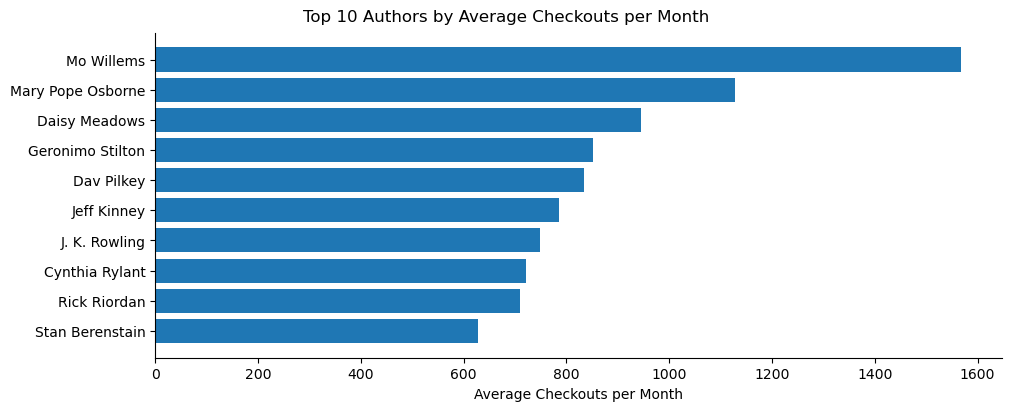

In [221]:
## Sort data to graph
top_authors_overall = top_authors.sort_values('AvgMonthlyCheckouts').tail(10)

## Build graph
fig, ax = plt.subplots(figsize = (10,4), layout = 'constrained')

ax.barh(np.arange(10), top_authors_overall['AvgMonthlyCheckouts'])

## Graph title
plt.suptitle('Top 10 Authors by Average Checkouts per Month')

## Axis & legend customization
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel("Average Checkouts per Month")
ax.set_yticks(np.arange(10))
ax.set_yticklabels(top_authors_overall['CreatorName'])

plt.show()

## Defining 'Popular'

### How much is the typical book checked out each month?
What is the distribution of checkouts for books vs ebooks vs audiobooks? 

In [224]:
book_summary = books_df.groupby(['CreatorName', 'Title', 'UsageClass', 'MaterialCategory', 'CheckoutDate'], as_index = False)['Checkouts'].sum()

In [225]:
book_summary

,CreatorName,Title,UsageClass,MaterialCategory,CheckoutDate,Checkouts
0,'Nathan Burgoine,Exit Plans For Teenage Freaks,Physical,Book,2019-01-01,3
1,'Nathan Burgoine,Exit Plans For Teenage Freaks,Physical,Book,2019-02-01,1
2,'Nathan Burgoine,Exit Plans For Teenage Freaks,Physical,Book,2019-08-01,1
3,'Nathan Burgoine,Exit Plans For Teenage Freaks,Physical,Book,2019-10-01,1
4,'Nathan Burgoine,Exit Plans For Teenage Freaks,Physical,Book,2020-01-01,1
...,...,...,...,...,...,...
6156058,ａｃｃｏｔｏｔｏふくだとしお＋あきこ,ポポくんのひみつきち,Digital,E-book,2025-06-01,1
6156059,ａｃｃｏｔｏｔｏふくだとしお＋あきこ,ポポくんのひみつきち,Digital,E-book,2025-07-01,1
6156060,ａｃｃｏｔｏｔｏふくだとしお＋あきこ,ポポくんのひみつきち,Digital,E-book,2025-08-01,1
6156061,ａｃｃｏｔｏｔｏふくだとしお＋あきこ,ポポくんのひみつきち,Digital,E-book,2025-09-01,1


Text(0, 0.5, 'Monthly Checkouts')

C:\Users\5pira\anaconda3\Lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
C:\Users\5pira\anaconda3\Lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))


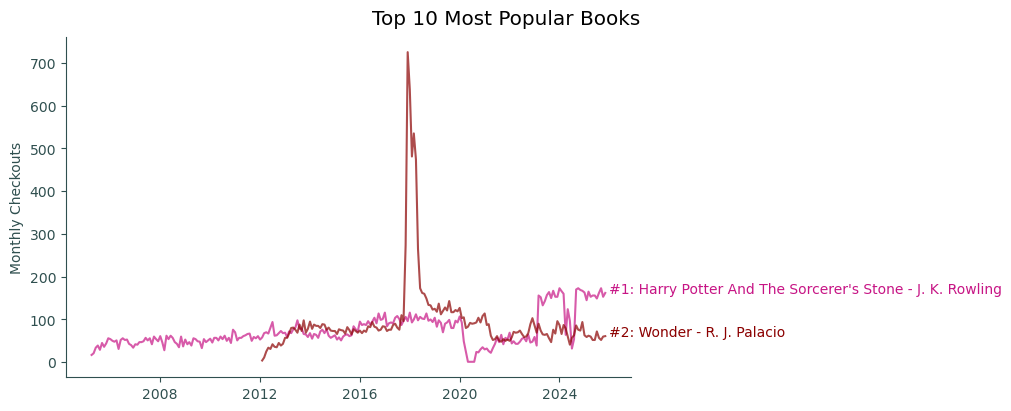

In [56]:
## Get data to graph
top2 = top10_overall.head(2)
top10_OT = pd.merge(juvenile_df, top2, how = 'inner', on = ['CreatorName', 'Title'])
colors = dict(zip(top10_overall.CreatorName.unique(), ['MediumVioletRed', 'DarkRed']))

## Build the graph
fig, ax = plt.subplots(figsize = (10,4), layout = 'constrained')

for i, r in top2.iterrows():
    title = r['Title']
    author = r['CreatorName']

    filtered = top10_OT.loc[top10_OT['Title'] == title].groupby(['Title', 'CreatorName', 'CheckoutDate'], as_index = False)['Checkouts'].sum()
    plt.plot(filtered['CheckoutDate'], filtered['Checkouts'], 
             color = colors.get(author), label = title, alpha = .7)

    plt.text(s = '#' + str(i+1) + ': ' + title + ' - ' + author, x = filtered['CheckoutDate'].max() + timedelta(days = 50), 
             y = filtered.loc[filtered['CheckoutDate'] == filtered['CheckoutDate'].max(), 'Checkouts'] ##550 - (i*60) ##
             , color = colors.get(author))


## Graph title
fig.suptitle('Top 10 Most Popular Books', size = 'x-large', color = 'black')

## axis customization:
ax.tick_params(axis = 'x', colors = 'darkslategray', labelrotation = 0)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('darkslategray')
ax.tick_params(axis = 'y', colors = 'darkslategray', labelrotation = 0)
ax.tick_params(axis = 'x', colors = 'darkslategray')
ax.set_ylabel('Monthly Checkouts', color = 'darkslategray')

##plt.savefig('', transparent = True) 

### Top monthly checkout numbers

In [15]:
top_monthly_checkouts = books_df.groupby(['CreatorName', 'Title', 'CheckoutDate'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).rename(columns = {'Checkouts': 'MonthlyCheckouts'}).head(10)

In [16]:
top_monthly_checkouts = pd.merge(top_monthly_checkouts, books_df.groupby(['CreatorName', 'Title', 'CheckoutDate', 'UsageClass'], as_index = False)['Checkouts'].sum(), how = 'inner', on = ['CreatorName', 'Title', 'CheckoutDate']).pivot(index = ['CreatorName', 'Title', 'CheckoutDate', 'MonthlyCheckouts'], columns = 'UsageClass', values = 'Checkouts').reset_index().sort_values('MonthlyCheckouts', ascending = False).reset_index(drop = True)

In [17]:
top_monthly_checkouts

UsageClass,CreatorName,Title,CheckoutDate,MonthlyCheckouts,Digital,Physical
0,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-04-01,2637,2637.0,NaN
1,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-05-01,1534,1534.0,NaN
2,J. K. Rowling,Harry Potter And The Sorcerer's Stone: Harry P...,2020-06-01,1081,1081.0,NaN
3,Christina Diaz Gonzalez,Invisible: A Graphic Novel,2023-11-01,850,850.0,NaN
4,Jeff Kinney,Hot Mess,2024-11-01,780,764.0,16.0
5,John Green,Turtles All The Way Down,2017-12-01,777,NaN,777.0
6,Andrea Davis Pinkney,The Red Pencil,2018-11-01,752,729.0,23.0
7,R. J. Palacio,Wonder,2017-12-01,725,63.0,662.0
8,John Green,Turtles All The Way Down,2018-01-01,654,NaN,654.0
9,Jeff Kinney,Partypooper,2025-11-01,651,645.0,6.0


### Authors with most monthly checkouts

In [18]:
top_author_checkouts = books_df.groupby(['CreatorName', 'CheckoutDate'], as_index = False).agg(Checkouts = ('Checkouts', 'sum'), Titles = ('Title', 'nunique')).sort_values('Checkouts', ascending = False).rename(columns = {'Checkouts': 'MonthlyCheckouts'}).head(10)

In [19]:
top_author_checkouts = pd.merge(top_author_checkouts, books_df.groupby(['CreatorName', 'CheckoutDate', 'UsageClass'], as_index = False)['Checkouts'].sum(), how = 'inner', on = ['CreatorName', 'CheckoutDate']).pivot(index = ['CreatorName', 'CheckoutDate', 'Titles', 'MonthlyCheckouts'], columns = 'UsageClass', values = 'Checkouts').reset_index().sort_values('MonthlyCheckouts', ascending = False).reset_index(drop = True)

In [20]:
top_author_checkouts

UsageClass,CreatorName,CheckoutDate,Titles,MonthlyCheckouts,Digital,Physical
0,J. K. Rowling,2020-04-01,41,3739,3739.0,NaN
1,Daisy Meadows,2014-07-01,205,3390,149.0,3241.0
2,Mo Willems,2015-11-01,58,3390,6.0,3384.0
3,Mo Willems,2016-10-01,56,3387,5.0,3382.0
4,Mo Willems,2018-01-01,65,3353,9.0,3344.0
5,Mo Willems,2017-11-01,63,3302,7.0,3295.0
6,Mo Willems,2017-01-01,56,3204,6.0,3198.0
7,Mo Willems,2016-11-01,56,3193,6.0,3187.0
8,Mo Willems,2016-01-01,57,3124,3.0,3121.0
9,Mo Willems,2017-03-01,57,3106,7.0,3099.0


### Top books each year

In [21]:
books_df['CheckoutYear'] = books_df.CheckoutDate.dt.year

In [22]:
top5_per_year = pd.DataFrame()

for year in books_df.CheckoutYear.unique():
    ## check number of months with data for that year, and only compare complete years
    months = books_df.loc[books_df['CheckoutYear'] == year, 'CheckoutDate'].unique()
    if len(months) == 12:
        df = books_df.loc[books_df['CheckoutYear'] == year].groupby(['CheckoutYear', 'CreatorName', 'Title'], as_index = False)['Checkouts'].sum().sort_values('Checkouts', ascending = False).head(5)
        df['Rank'] = [1, 2, 3, 4, 5]
        top5_per_year = pd.concat([top5_per_year, df])

In [23]:
top5_per_year = top5_per_year.sort_values(['CheckoutYear', 'Checkouts'], ascending = [True, False])

In [24]:
pd.set_option('display.max_rows', None)
top5_per_year

,CheckoutYear,CreatorName,Title,Checkouts,Rank
3743,2006,J. K. Rowling,Harry Potter And The Half-blood Prince,1921,1
1027,2006,Bobby Lynn Maslen,Bob Books First!,1547,2
1028,2006,Bobby Lynn Maslen,Bob Books Fun!,1419,3
3744,2006,J. K. Rowling,Harry Potter And The Order Of The Phoenix,777,4
1031,2006,Bobby Lynn Maslen,Bob Books. Pals!,664,5
4444,2007,J. K. Rowling,Harry Potter And The Deathly Hallows,1923,1
4446,2007,J. K. Rowling,Harry Potter And The Half-blood Prince,1669,2
1227,2007,Bobby Lynn Maslen,Bob Books Fun!,1463,3
1226,2007,Bobby Lynn Maslen,Bob Books First!,1330,4
4447,2007,J. K. Rowling,Harry Potter And The Order Of The Phoenix,803,5


### Top authors per year

In [25]:
top5_authors_py = pd.DataFrame()

for year in books_df.CheckoutYear.unique():
    ## check number of months with data for that year, and only compare complete years
    months = books_df.loc[books_df['CheckoutYear'] == year, 'CheckoutDate'].unique()
    if len(months) == 12:
        df = books_df.loc[books_df['CheckoutYear'] == year].groupby(['CheckoutYear', 'CreatorName'], as_index = False).agg(Checkouts = ('Checkouts', 'sum'), Titles = ('Title', 'nunique')).sort_values('Checkouts', ascending = False).head(5)
        df['Rank'] = [1, 2, 3, 4, 5]
        top5_authors_py = pd.concat([top5_authors_py, df])

In [26]:
top5_authors_py = top5_authors_py.sort_values(['CheckoutYear', 'Checkouts'], ascending = [True, False])

In [27]:
top5_authors_py

,CheckoutYear,CreatorName,Checkouts,Titles,Rank
738,2006,Cynthia Rylant,8355,85,1
2402,2006,Marc Tolon Brown,5867,32,2
2576,2006,Mary Pope Osborne,5574,46,3
1839,2006,Jonathan London,5291,30,4
1471,2006,J. K. Rowling,5115,19,5
838,2007,Cynthia Rylant,9885,90,1
1668,2007,J. K. Rowling,7006,22,2
2940,2007,Mary Pope Osborne,6750,56,3
2741,2007,Marc Tolon Brown,5747,36,4
2093,2007,Jonathan London,5637,32,5


In [28]:
pd.reset_option('display.max_rows')

### Consistancy

#### Which titles had the biggest spikes in popularity?

In [29]:
def q25(x):
    return x.quantile(.25)

In [30]:
def q75(x):
    return x.quantile(.75)

In [31]:
books_spread = books_df.groupby(['Title', 'CreatorName'], as_index = False)['Checkouts'].agg(['count', 'mean', 'min', q25, 'median', q75, 'max'])

In [32]:
books_spread['range'] = books_spread['max'] - books_spread['min']

In [33]:
books_spread['IQR'] = books_spread['q75'] - books_spread['q25']

In [34]:
books_spread = books_spread.rename(columns = {'count': 'months'})

In [35]:
books_spread.sort_values('range', ascending = False).head(10)

,Title,CreatorName,months,mean,min,q25,median,q75,max,range,IQR
36913,Harry Potter And The Sorcerer's Stone: Harry P...,J. K. Rowling,85,124.423529,11,24.00,77.0,109.00,1894,1883,85.0
43936,Invisible: A Graphic Novel,Christina Diaz Gonzalez,65,46.800000,1,4.00,16.0,30.00,802,801,26.0
111914,Turtles All The Way Down,John Green,93,46.290323,1,5.00,9.0,24.00,777,776,19.0
101970,The Red Pencil,Andrea Davis Pinkney,320,9.915625,1,1.00,2.0,5.00,716,715,4.0
119053,Wonder,R. J. Palacio,725,22.009655,1,3.00,8.0,30.00,654,653,27.0
94978,The Hate U Give,Angie Thomas,101,80.623762,1,9.00,17.0,61.00,595,594,52.0
39473,Hot Mess,Jeff Kinney,52,95.096154,1,23.75,74.0,116.25,539,538,92.5
3595,A Wrinkle In Time,Madeleine L'Engle,544,26.066176,1,2.00,10.0,26.00,528,527,24.0
67343,Partypooper,Jeff Kinney,5,182.200000,6,110.00,150.0,192.00,453,447,82.0
53338,Lunar Boy: A Graphic Novel,Jes and Cin Wibowo,11,44.909091,4,4.00,5.0,6.00,443,439,2.0


#### Which titles had the most consistent popularity?

What does it mean to have consistent popularity?  
* Small IQR (the book is usually checked out the same number of times each month)

But that only finds *consistency*, we also need to find *popularity*
* High checkout numbers

If we do max div by IQR, bigger number is better?

In [36]:
books_spread['meas'] = books_spread['range'] / (books_spread['IQR'] + 1)

In [37]:
books_spread.loc[(books_spread.months >= 12) & (books_spread.meas > 0)].sort_values('meas', ascending = True)

,Title,CreatorName,months,mean,min,q25,median,q75,max,range,IQR,meas
111826,Tunnel Vision,Susan Adrian,14,1.500000,1,1.0,1.5,2.00,2,1,1.00,0.500000
96378,The Kitten Story: A Mostly True Tale,Emily Jenkins,13,1.307692,1,1.0,1.0,2.00,2,1,1.00,0.500000
61555,Nancy Clancy Seeks A Fortune: Nancy Clancy See...,Jane O'Connor,14,1.357143,1,1.0,1.0,2.00,2,1,1.00,0.500000
71777,Rabbit Ears Christmas Stories. Volume One.,Random House,17,1.294118,1,1.0,1.0,2.00,2,1,1.00,0.500000
52419,"Los Tipos Malos: Serie Los Tipos Malos, Libro 1",Aaron Blabey,25,1.320000,1,1.0,1.0,2.00,2,1,1.00,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
71762,Rabbit Chase,Elizabeth LaPensée,43,21.627907,1,2.0,3.0,4.50,298,297,2.50,84.857143
81355,"Spirit Hunters: Spirit Hunters Series, Book 1",Ellen Oh,36,18.944444,1,3.0,4.0,4.25,195,194,1.25,86.222222
89665,The Case Of Windy Lake,Michael Hutchinson,95,10.031579,1,1.0,1.0,2.00,207,206,1.00,103.000000
114916,We Are Big Time: (A Graphic Novel),Hena Khan,16,26.187500,2,3.0,4.0,4.75,359,357,1.75,129.818182


In [38]:
books_spread.loc[books_spread.CreatorName == 'J. K. Rowling']

,Title,CreatorName,months,mean,min,q25,median,q75,max,range,IQR,meas
6665,Animales Fantásticos Y Dónde Encontrarlos,J. K. Rowling,23,1.130435,1,1.0,1.0,1.00,3,2,0.00,2.000000
17514,Christmas At Hogwarts : From Harry Potter And ...,J. K. Rowling,12,5.250000,1,2.0,4.0,7.50,15,14,5.50,2.153846
26027,El Cerdito De Navidad,J. K. Rowling,11,1.000000,1,1.0,1.0,1.00,1,0,0.00,0.000000
26255,El Ickabog,J. K. Rowling,9,1.000000,1,1.0,1.0,1.00,1,0,0.00,0.000000
29329,Fantastic Beasts & Where To Find Them,J. K. Rowling,173,10.797688,1,2.0,6.0,16.00,47,46,14.00,3.066667
...,...,...,...,...,...,...,...,...,...,...,...,...
103339,The Secrets Of Dumbledore: The Complete Screen...,J. K. Rowling,40,3.225000,1,2.0,2.5,5.00,8,7,3.00,1.750000
105305,The Tales Of Beedle The Bard,J. K. Rowling,266,18.586466,1,4.0,13.0,25.00,133,132,21.00,6.000000
120066,Yin You Shi Ren Pituo Gu Shi Ji,J. K. Rowling,6,1.166667,1,1.0,1.0,1.00,2,1,0.00,1.000000
123002,哈利·波特与被诅咒的孩子（第一部和第二部）: 伦敦西区原创舞台剧的官方剧本,J. K. Rowling,2,1.000000,1,1.0,1.0,1.00,1,0,0.00,0.000000


In [39]:
books_spread['upper_bound'] = books_spread['q75'] + (1.5 * books_spread['IQR'])

In [40]:
books_spread['lower_bound'] = books_spread['q25'] - (1.5 * books_spread['IQR'])

Other questions to explore:
* How does releasing a new book impact an author's popularity in the next 12 months? 60 months?
* Are books that win awards more popular than books that didn't?